In [36]:
# Imported Libraries

#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')




# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import collections
from sklearn.model_selection import cross_val_score




from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import time
from datetime import datetime

import warnings
!pip install lightgbm
import lightgbm as lgb
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("predictive_maintenance_dataset.csv")

In [4]:
df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/2015,S1F01085,0,215630672,55,0,52,6,407438,0,0,7
1,1/1/2015,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/2015,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/2015,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/2015,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [5]:
df.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.492706,9.940897,1.741120,14.222669,260172.657726,0.292528,0.292528,13.013848
std,0.029167,7.045933e+07,2179.677781,185.748131,22.908507,15.943028,99151.078547,7.436924,7.436924,275.661220
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,70000.000000


In [6]:
df.shape

(124494, 12)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   date     124494 non-null  object
 1   device   124494 non-null  object
 2   failure  124494 non-null  int64 
 3   metric1  124494 non-null  int64 
 4   metric2  124494 non-null  int64 
 5   metric3  124494 non-null  int64 
 6   metric4  124494 non-null  int64 
 7   metric5  124494 non-null  int64 
 8   metric6  124494 non-null  int64 
 9   metric7  124494 non-null  int64 
 10  metric8  124494 non-null  int64 
 11  metric9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [8]:
df.isnull().sum()

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

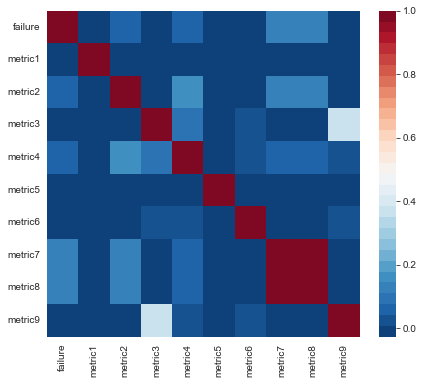

In [9]:
plt.figure(figsize=(7,6))
sns.heatmap(df.corr(),  cmap=sns.color_palette("RdBu_r", 30));

In [10]:
# removing metric7 column
df = df.drop(columns='metric7')

In [11]:
# check for outlier, we use z-score to check if there are any outlier
z_score = df.loc[:,'metric1':'metric9'].copy()
z_score = z_score.sub(z_score.mean(), axis=1).div(z_score.std(), axis=1)
outliers = (abs(z_score) > 3).sum().sort_values()
outliers

metric1       0
metric6      80
metric8     253
metric3     435
metric2     456
metric9     516
metric4     728
metric5    4749
dtype: int64

Text(0.5, 0, 'Number of Outliers')

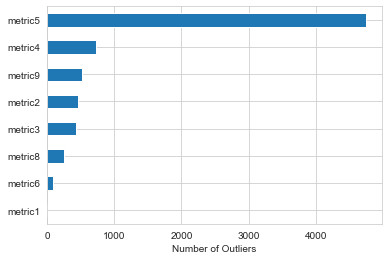

In [12]:
outliers.plot(kind='barh')
plt.xlabel('Number of Outliers')

In [13]:
# convert date columns to datetime
df['date'] = pd.to_datetime(df['date'])
# From date column, we create new date-related features: 'Day of Week', 'Day' and 'Month'.
df['Day of Week'] = df['date'].apply(lambda time: time.dayofweek)
df['Day'] = df['date'].apply(lambda time: time.day).astype(int)
df['Month'] = df['Month'] = df['date'].apply(lambda time: time.month)
#Day of Week is an integer 0-6. I made a dictionary to map the actual string names to the day of the week:
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}

In [14]:
#Converting numerical week days to alphabetical format. 
df['Day of Week'] = df['Day of Week'].map(dmap)

In [15]:
df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric8,metric9,Day of Week,Day,Month
0,2015-01-01,S1F01085,0,215630672,55,0,52,6,407438,0,7,Thu,1,1
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,Thu,1,1
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,Thu,1,1
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,Thu,1,1
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3,Thu,1,1


In [16]:
#checking number of failure per month
byMonth= df[(df['failure'] == 1)].groupby('Month').count()
byMonth['device']

Month
1     24
2     14
3      9
4      9
5     21
6      6
7     16
8      4
10     3
Name: device, dtype: int64

In [17]:
df.groupby('Month')['failure'].agg(['size', 'mean'])

,size,mean
Month,,
1,25032,0.000959
2,19500,0.000718
3,19833,0.000454
4,12012,0.000749
5,11330,0.001853
6,10469,0.000573
7,10531,0.001519
8,8346,0.000479
9,4470,0.000000


In [18]:
#counting how many devices are failed in each day of week, separating them monthly.
ByFail=df[df['failure']==1]
ByFail.groupby(by=['Day of Week', 'Month']).count()['device'].unstack().fillna(0).astype(int)

Month,1,2,3,4,5,6,7,8,10
Day of Week,,,,,,,,,
Fri,3,1,0,2,3,1,1,0,1
Mon,10,5,0,3,2,0,3,2,2
Sat,1,2,0,0,2,0,3,0,0
Sun,1,0,0,0,0,1,2,0,0
Thu,3,2,3,2,6,2,4,0,0
Tue,3,0,4,2,4,1,2,2,0
Wed,3,4,2,0,4,1,1,0,0


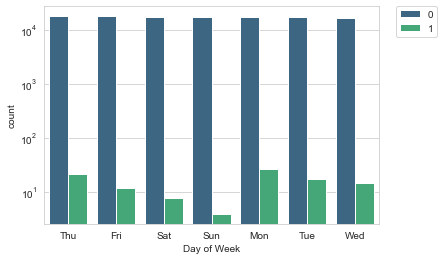

In [19]:
#Now I use seaborn library to create a countplot of the Day of Week column and failure
sns.countplot(x='Day of Week',data=df,hue='failure',palette='viridis')

# To relocate the legend:
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log')

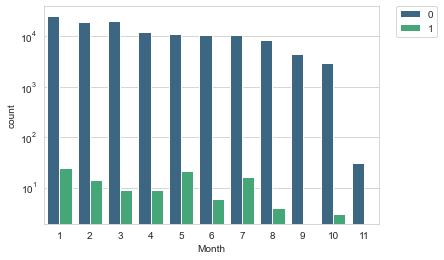

In [20]:
#We do the same to check failure in different months and numbers are months respectely (January =1 , February =2 and so on)
sns.countplot(x='Month',data=df,hue='failure',palette='viridis')

# To relocate the legend:
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log')

As we go further toward the end of the year, number of monthly failures decreases

In [21]:
df['device'].nunique()

1169

In [22]:
df.groupby('failure')['device'].nunique()

failure
0    1169
1     106
Name: device, dtype: int64

In our 1169 different types of devices and 124494 recording reports, only 106 devices show some sort of failure.

<AxesSubplot:ylabel='device'>

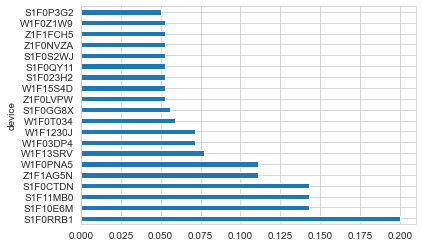

In [23]:
# percetange of failure for each device
t = df.groupby(by = 'device')['failure'].mean()
t.sort_values(ascending=False).head(20).plot(kind='barh')

# Feature Engineering


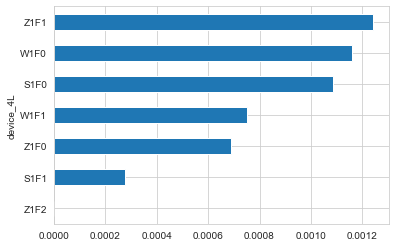

In [24]:
# instead of using device as a feature, we use only the first 4 letters(of devices) to reduce the number of dummies we need to modeling
# percentage of failure based on the first 4 letters of device
df['device_4L'] = df['device'].str[:4]
df.groupby('device_4L')['failure'].mean().sort_values().plot(kind='barh');

In [25]:
# process of making dummy variables for two categorical and timestamp columns.
df_dummy = pd.get_dummies(df, columns=['Day of Week', 'device_4L'],drop_first = True)
df_dummy = df_dummy.drop(columns=['date', 'device'])

In [26]:
#we will first scale the Metric columns that are skewed. We need to scale and standardize our dataset.
scaler = StandardScaler()
df_scaled = df_dummy.copy()
df_scaled[:] = scaler.fit_transform(df_dummy)
df_scaled['failure'] = df_dummy['failure'].copy()

In [ ]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

In [28]:
#Stratified K-Folds cross-validator that provides train/test indices to split data in train/test sets
#This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

In [29]:
# Caculating accuracy of each classifier
from sklearn.model_selection import cross_val_score

X = df_scaled.drop(columns='failure')
y = df_scaled['failure']

for key, classifier in classifiers.items():
    training_score = cross_val_score(classifier, X, y, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 4) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 99.9 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 99.91 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 95.39 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 99.85000000000001 % accuracy score


Since the response is highly imbalanced, accuracy is not a good metric to evaluate different models. AUC is the primary evaluation metric

In [30]:
# Use RandomizedSearchCV to find the best parameters.
from sklearn.model_selection import RandomizedSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, scoring='roc_auc')
rand_log_reg.fit(X, y)
# We automatically get the logistic regression with the best parameters.
log_reg = rand_log_reg.best_estimator_
print(rand_log_reg.best_params_)

# Knearest Neighbor Classifier
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
rand_knears = RandomizedSearchCV(KNeighborsClassifier(), knears_params, scoring='roc_auc')
rand_knears.fit(X, y)
# KNears best estimator
knears_neighbors = rand_knears.best_estimator_
print(rand_knears.best_params_)

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
rand_tree = RandomizedSearchCV(DecisionTreeClassifier(), tree_params, scoring='roc_auc')
rand_tree.fit(X, y)

# Decision Tree best estimator
tree_clf = rand_tree.best_estimator_
print(rand_tree.best_params_)

# RandomForest Classifier
rf_params = {"criterion": ["gini", "entropy"], "max_depth": [4,8,12], 
              "max_features": [5, 10, 15]}
rand_rf = RandomizedSearchCV(RandomForestClassifier(), rf_params, scoring='roc_auc')
rand_rf.fit(X, y)
# Random Forest best estimator
rf_clf = rand_rf.best_estimator_
print(rand_rf.best_params_)

{'penalty': 'l2', 'C': 0.001}
{'n_neighbors': 4, 'algorithm': 'brute'}
{'min_samples_leaf': 5, 'max_depth': 3, 'criterion': 'entropy'}
{'max_features': 15, 'max_depth': 4, 'criterion': 'gini'}


In [31]:
log_reg_pred = cross_val_predict(log_reg, X, y, cv=3, method='predict_proba')
knears_pred = cross_val_predict(knears_neighbors, X, y, cv=3, method='predict_proba')
tree_pred = cross_val_predict(tree_clf, X, y, cv=3, method='predict_proba')
rf_pred = cross_val_predict(rf_clf, X, y, cv=3, method='predict_proba')

In [32]:
log_reg_pred = cross_val_predict(log_reg, X, y, cv=3, method='predict_proba')
knears_pred = cross_val_predict(knears_neighbors, X, y, cv=3, method='predict_proba')
tree_pred = cross_val_predict(tree_clf, X, y, cv=3, method='predict_proba')
rf_pred = cross_val_predict(rf_clf, X, y, cv=3, method='predict_proba')

<AxesSubplot:>

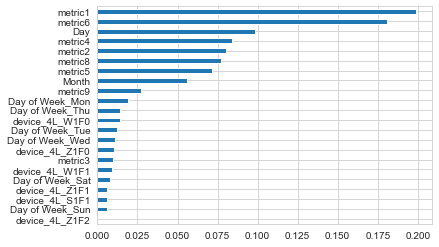

In [33]:
#Checking Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X,y)
pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(kind='barh')


Above figure shows the feature importance from Random Forest. It shows that metric1 and metric6 has the highest importance to separating response. Features generated from date is not as important as metrics.

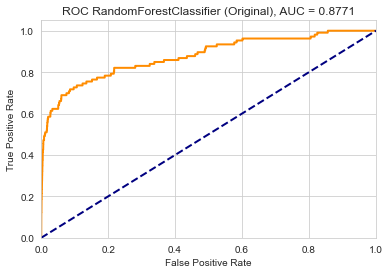

In [43]:
# We apply Random Forest Classifier on original data (without any oversampling or under sampling and check the AUC result)
from sklearn.metrics import roc_curve
X_np = X.values
y_np = y.values

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
y_prob = np.zeros(y_np.shape)
for train, test in kf.split(X_np, y_np):
  rf = RandomForestClassifier(max_depth=12, max_features = 6, random_state=123)  
  rf.fit(X_np[train], y_np[train])
  y_prob[test] = rf.predict_proba(X_np[test])[:,1]

fpr, tpr, thresholds = roc_curve(y_np, y_prob)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',  lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC RandomForestClassifier (Original), AUC = {0:.4f}'.format(roc_auc_score(y_np, y_prob)))
plt.show()

In [48]:
# We apply Random Forest and using SMOTE oversampling technique

oversample_accuracy = []
oversample_precision = []
oversample_recall = []
oversample_f1 = []
oversample_auc = []
oversample_prediction = np.zeros(y_np.shape)
oversample_prob = np.zeros(y_np.shape)
for train, test in sss.split(X_np, y_np):
    oversample_pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), RandomForestClassifier(max_depth=12, max_features=6, random_state=123)) # SMOTE happens during Cross Validation not before..
    oversample_model = oversample_pipeline.fit(X_np[train], y_np[train])
    oversample_prediction[test] = oversample_model.predict(X_np[test])
    oversample_prob[test] = oversample_model.predict_proba(X_np[test])[:,1]

    oversample_accuracy.append(oversample_pipeline.score(X_np[test], y_np[test]))
    oversample_precision.append(precision_score(y_np[test], oversample_prediction[test]))
    oversample_recall.append(recall_score(y_np[test], oversample_prediction[test]))
    oversample_f1.append(f1_score(y_np[test], oversample_prediction[test]))
    oversample_auc.append(roc_auc_score(y_np[test], oversample_prob[test]))
np.mean(oversample_f1) 

fpr, tpr, thresholds = roc_curve(y_np, oversample_prob)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',  lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC RandomForestClassifier (Oversampled), AUC = {0:.4f}'.format(roc_auc_score(y_np, oversample_prob)))
plt.legend(loc="lower right")
plt.show()

NameError: name 'sss' is not defined

Applying Random Forest on Original data shows the best AUC.

# A Deeper Look into RandomForest:

In [44]:
#Confusion matrix
rf_cf = confusion_matrix(y, y_pred_rf)
sns.heatmap(rf_cf, annot=True, cmap=plt.cm.copper, fmt='d')
plt.title("RandomForest Classifier \n Confusion Matrix", fontsize=14)

NameError: name 'y_pred_rf' is not defined

In [49]:
best_thr = np.argmax(f1_list)
y_pred_rf = 1*(y_prob>thrs[best_thr])
print('Random Forest Classifier:')
print(classification_report(y, y_pred_rf))

NameError: name 'f1_list' is not defined

In [50]:
best_thr_over = np.argmax(f1_list)
y_pred_oversample_rf = 1*(oversample_prob>thrs[best_thr_over])
print('Random Forest Classifier:')
print(classification_report(y, y_pred_oversample_rf))

NameError: name 'f1_list' is not defined

I aggregated over each device (we had 1168 devices) and then calculated the confusion matrix. For predicting failure which is what we want (The ture positive), This model (Random Forest on Original data) catches about half the cases(54%) using a cutoff of 0.3

In [51]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
y_prob = np.zeros(y_np.shape)
for train, test in kf.split(X_np, y_np):
  rf = RandomForestClassifier(max_depth=12, random_state=123, max_features=6) 
  rf.fit(X_np[train], y_np[train])
  y_prob[test] = rf.predict_proba(X_np[test])[:,1]

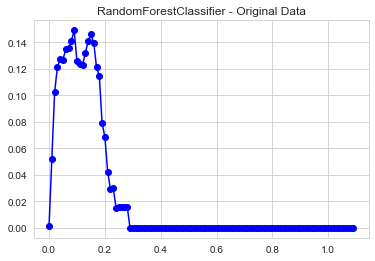

In [52]:
f1_list = []
thrs = np.arange(0,1.1,.01)
for thr in thrs:
  f1_list.append(f1_score(y_np, 1*(y_prob>thr)))
plt.plot(thrs, f1_list, 'b-o')
plt.title('RandomForestClassifier - Original Data');

In [53]:
confusion_matrix(y_np, y_pred_rf)

NameError: name 'y_pred_rf' is not defined

In [ ]:
#read our data again
df = pd.read_csv(io.StringIO(uploaded['predictive_maintenance.csv'].decode('utf-8'))).drop(columns='metric8')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['device', 'date'])

In [ ]:
#Having a time series plot to check recording trend 
plt.figure(figsize=(8,7))
df.groupby('date').size().plot()
#sns.rugplot(df['date'])
plt.xlabel('date')
plt.ylabel('number of records')

As we can see, number of records decreasing over time, representing a shrinking of the device population as time proceeds.

EDA Device Time Series

In [ ]:
#We chose the 4 types of devices withe most failure
withfailure = df.groupby('device').filter(lambda x: x['failure'].sum() > 0)
selected = withfailure['device'].unique()[:4]

withfailure[withfailure['device'].isin(selected)].pivot(index='date', columns='device', values='failure').fillna(1).plot(subplots=True, layout=(4,1), figsize=(8,8));

In [ ]:
bydevice = df.groupby('device')['failure'].agg(['mean', 'size']).sort_values('size', ascending=False)
passed = bydevice[bydevice['mean'] == 0].index[:4]

metrics = df.columns[df.columns.str.contains('met')]
plt.figure(figsize=(25, 8))
for i, met in enumerate(metrics):
  ax = plt.subplot(2,4,i+1)
  df[df['device'].isin(passed)].pivot(index='date', columns='device', values=met).plot(ax=ax);
  plt.title(met)
plt.tight_layout()

In [ ]:
failed = bydevice[bydevice['mean'] != 0].sample(4, random_state=123).index
plt.figure(figsize=(25, 8))
for i, met in enumerate(metrics):
  ax = plt.subplot(2,4,i+1)
  df[df['device'].isin(failed)].pivot(index='date', columns='device', values=met).plot(ax=ax);
  plt.title(met)
plt.tight_layout()

In [ ]:
#defining more attributes for evaluation 
cols = [f'{x}_mean' for x in metrics] + [f'{x}_std' for x in metrics] + [f'{x}_diff' for x in metrics] + [f'{x}_min' for x in metrics] + [f'{x}_max' for x in metrics] + [f'{x}_slope' for x in metrics] 
def device_aggregation(rows):
  f1 = rows[metrics].mean()
  f2 = rows[metrics].std()
  f3 = rows[metrics].diff().mean()
  f4 = rows[metrics].min()
  f5 = rows[metrics].max()
  f6 = rows[metrics].iloc[0,:] - rows[metrics].iloc[-1,:] 
  res = pd.concat((f1,f2,f3,f4,f5,f6))
  res.index = cols
  res['failure'] = rows['failure'].any()
  return res

In [ ]:
#making a new dataframe
newdf = df.groupby('device').apply(device_aggregation).dropna()

In [ ]:
X = newdf.drop(columns='failure')
y = newdf['failure']

In [ ]:
rf = RandomForestClassifier()
rf.fit(X,y)
pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(kind='barh', figsize=(6,8));

In [ ]:
rf_pred[:,1]

In [ ]:
rf_pred = cross_val_predict(RandomForestClassifier(max_depth=16, max_features=5, random_state=241), X, y, cv=5, method='predict_proba')

fpr, tpr, thresholds = roc_curve(y, rf_pred[:,1])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',  lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC GradientBoostingClassifier, AUC = {0:.4f}'.format(roc_auc_score(y,  rf_pred[:,1])))
plt.legend(loc="lower right")
plt.show()

In [ ]:
f1_list = []
thrs = np.arange(0,1.1,.01)
for thr in thrs:
  f1_list.append(f1_score(y, 1*(rf_pred[:,1]>thr)))
plt.plot(thrs, f1_list, 'b-')

best_thr = np.argmax(f1_list)
plt.plot(thrs[best_thr], f1_list[best_thr], 'ro')
plt.title('RandomForestClassifier');
plt.xlabel('Threshold')
plt.ylabel('F1-Score');

In [ ]:
y_class = 1*(rf_pred[:,1]>thrs[best_thr])
print('Random Forest Classifier:')
print(classification_report(y, y_class))

In [ ]:
rf_cf = confusion_matrix(y, y_class)
sns.heatmap(rf_cf, annot=True, cmap=plt.cm.copper, fmt='d')
plt.title("RandomForest Classifier \n Confusion Matrix", fontsize=14);

In [ ]:
cost_list = []
thrs = np.arange(0,1.1,.01)
fp_cost = 1    #1$
fn_cost = 2    #2$
for thr in thrs:
  preds = 1*(rf_pred[:,1]>thr)
  fp = np.sum((y.values == 0) & (preds == 1))
  fn = np.sum((y.values == 1) & (preds == 0))
  cost_list.append(fp*fp_cost + fn_cost*fn )
plt.plot(thrs, cost_list, '-')
best_thr = np.argmin(cost_list)
plt.plot(thrs[best_thr], cost_list[best_thr], 'ro')
plt.title('RandomForestClassifier');
plt.xlabel('Threshold')
plt.ylabel('Cost');
# false positive, device is not failed but labaled as failed ($1)
# false negative, device is failed but labaled as passed ($2)

## Conclusion
1. Response is highly imbalanced.
2. Features are not representing the response a lot (they have very low correlation).
3. Because data is imbalanced, we use probablity + roc_auc score to find the best model, becasue roc is not dependent on threshold for classficaiton.
4. From all five machine learning techniques that I used (Logistic Regression,KNN, Decision Tree, Random Forest and Gradient Boosting), Gradient boosting and Random Forest had the best result. Then I used Oversampling(SMOTE) and Undersampling(NearMiss) techniques to make a balanced training set while using Random Forest and Oversampled trainig set and they didn't improve in AUC score.
5. For finding the optimal model, we used a search to find the optimal threshold to maximize F1-score. 
6. The cost associated with false positive and false negative is not known. Otherwise, we could have determine the threshold to minize the average cost.
7. With more data, we might be able to make better predictions, and could incorporate other techniques such as neural networks into the analysis. With more information on the cost of false negative/positives, we could also try updating a GBM model with a custom objective function to further optimize the training. In the real world, we might spend some research time digging into some of the attribute values to see if encoding specific values might also give lift to the model. 
